In [1]:
import os
import sys
import numpy as np
import pandas as pd
import itertools
import yaml
import pickle
import multiprocessing
import time 
import matplotlib.pyplot as plt
%matplotlib inline
import ipywidgets as widgets
from collections import OrderedDict

repo_dir = os.path.dirname(os.path.dirname(os.path.abspath("")))
sys.path.append(repo_dir)

from rmg_gua.gua_cantera.Spinning_basket_reactor.sbr import MinSBR

import_julia = True
if import_julia: 
# rms imports
    impt1 = time.time()
    from pyrms import rms
    from diffeqpy import de
    from julia import Main
    from rmg_gua.gua_rms.sbr import rms_sbr
    from rmg_gua.gua_peuqse.peuqse_utilities import get_highest_rms_file
    impt2 = time.time()
    print(f"import of julia packages took {impt2-impt1} seconds")

cantera version:  2.6
import of julia packages took 64.49178194999695 seconds


## 1. load the peuqse optimization results

In [2]:
# load the results pickle file: 
with open('./mcmc_map_logP.pkl', 'rb') as f:
    peuq_map_logp = pickle.load(f)

with open("./example_peuqse_results.pkl", 'rb') as f:
    peuq_results = pickle.load(f) 

# get all results with the same logP (sometimes peuqse has duplicate values)
match_res_list = []
for res in peuq_results:
    if res[0] == peuq_map_logp[0]:
        match_res_list.append(res)

match_res_list = np.array(match_res_list)

# Check that all the results with the same logP are in fact identical
if not (match_res_list == match_res_list[0]).all():
    raise Exception("Results with the same logP are not identical!")

params = match_res_list[0][1:].astype(float).tolist()


In [3]:
# we need to load the old list of parameters, since we have added more. 
with open("../gua_peuqse/peuqse_runs/test_run/config/rule_config.yaml", 'r') as f:
    rule_config_unflat = yaml.safe_load(f)

with open("../gua_peuqse/peuqse_runs/test_run/config/rule_unc_config.yaml", 'r') as f:
    rule_unc_config_unflat = yaml.safe_load(f)

with open("../gua_peuqse/peuqse_runs/test_run/config/rule_ub_config.yaml", 'r') as f:
    rule_ub_unflat = yaml.safe_load(f)

with open("../gua_peuqse/peuqse_runs/test_run/config/rule_lb_config.yaml", 'r') as f:
    rule_lb_unflat = yaml.safe_load(f)


# expand rule config and rule uncertainty so it is flat and not nested dict
rule_config = {}
minmax_dict = {}
for key, value in rule_config_unflat.items():
    for k, v in value.items():
        rule_config["_".join([key,k])] = v
        # for the uncertainty, if the value is <0, use ub/lb. else, use +/- unc. 
        if rule_unc_config_unflat[key][k] < 0:
            minmax_dict["_".join([key,k])] = (rule_lb_unflat[key][k],rule_ub_unflat[key][k])
        else: 
            minmax_dict["_".join([key,k])] = (v - rule_unc_config_unflat[key][k], v + rule_unc_config_unflat[key][k])

# open the thermo perturbation config files
with open('../gua_peuqse/peuqse_runs/test_run/config/be_values.yaml', 'r') as f:
    be_values = yaml.safe_load(f)

with open("../gua_peuqse/peuqse_runs/test_run/config/be_unc.yaml", 'r') as f:    
    be_unc = yaml.safe_load(f)

# be's are going to just be +/- unc
for key, value in be_values.items():
    minmax_dict[key] = (value - be_unc[key], value + be_unc[key])


label_list = list(rule_config.keys()) + list(be_values.keys())
param_dict = dict(zip(label_list, params))


### match up the parameters we are modifying

In [4]:
with open("./config/rule_config.yaml", 'r') as f:
   rule_config_unflat = yaml.safe_load(f)

with open("./config/rule_unc_config.yaml", 'r') as f:
    rule_unc_config_unflat = yaml.safe_load(f)

with open("./config/rule_ub_config.yaml", 'r') as f:
    rule_ub_unflat = yaml.safe_load(f)

with open("./config/rule_lb_config.yaml", 'r') as f:
    rule_lb_unflat = yaml.safe_load(f)


# expand rule config and rule uncertainty so it is flat and not nested dict
rule_config = {}
minmax_dict = {}
for key, value in rule_config_unflat.items():
    for k, v in value.items():
        rule_config["_".join([key,k])] = v
        # for the uncertainty, if the value is <0, use ub/lb. else, use +/- unc. 
        if rule_unc_config_unflat[key][k] < 0:
            minmax_dict["_".join([key,k])] = (rule_lb_unflat[key][k],rule_ub_unflat[key][k])
        else: 
            minmax_dict["_".join([key,k])] = (v - rule_unc_config_unflat[key][k], v + rule_unc_config_unflat[key][k])

# open the thermo perturbation config files
with open('./config/be_values.yaml', 'r') as f:
    be_values = yaml.safe_load(f)

with open("./config/be_unc.yaml", 'r') as f:    
    be_unc = yaml.safe_load(f)

# be's are going to just be +/- unc
for key, value in be_values.items():
    minmax_dict[key] = (value - be_unc[key], value + be_unc[key])


label_list_updated = list(rule_config.keys()) + list(be_values.keys())
# param_dict = dict(zip(label_list, params))

# if len(param_dict) != len(label_list):
#     raise Exception("Param dict and label list are not the same length!")

In [5]:
for label in label_list_updated:
    if label not in label_list:
        param_dict[label] = rule_config[label]
        print("adding {} with value {} since it is in updated model".format(label, param_dict[label]))

for label in label_list:
    if label not in label_list_updated:
        param_dict.pop(label)
        print("removing item {} since it is not in updated config".format(label))

# move the binding energies to the end of the dictionary. the sbr class expects them to be at the end.
updated_param_dict = OrderedDict(param_dict)
for key in be_values.keys():
    updated_param_dict.move_to_end(key)

param_dict = dict(updated_param_dict)

adding Surface_Abstraction : Abstracting;Donating_A with value 17.621176281775035 since it is in updated model
adding Surface_Abstraction : Abstracting;Donating_E0 with value 99300.0 since it is in updated model
adding Surface_Abstraction : Abstracting;Donating_alpha with value 0.37 since it is in updated model
adding Surface_Abstraction_Single_vdW : C-OH;*C=R_A with value 13.0 since it is in updated model
adding Surface_Abstraction_Single_vdW : C-OH;*C=R_E0 with value 0.0 since it is in updated model
adding Surface_Abstraction_Single_vdW : C-OH;*C=R_alpha with value 0.5 since it is in updated model
adding Surface_Abstraction_vdW : C-OH;*=C=R_A with value 13.0 since it is in updated model
adding Surface_Abstraction_vdW : C-OH;*=C=R_E0 with value 11326.088 since it is in updated model
adding Surface_Abstraction_vdW : C-OH;*=C=R_alpha with value 0.5 since it is in updated model
adding Surface_Adsorption_Dissociative : Adsorbate;VacantSite1;VacantSite2_A with value -1.0 since it is in upd

In [6]:
# put in a float slider
widge_list = []
for param, value in param_dict.items():
    widge_list.append(widgets.FloatSlider(
        value=value,
        min=minmax_dict[param][0],
        max=minmax_dict[param][1],
        # step=0.1,
        description=param,
        style = {'description_width': '500px'},
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        layout={'width': '800px'},
        )

    )
for widge in widge_list:
    display(widge)


FloatSlider(value=17.261603974885787, continuous_update=False, description='Surface_Abstraction : O;*C-H_A', l…

FloatSlider(value=126252.532640733, continuous_update=False, description='Surface_Abstraction : O;*C-H_E0', la…

FloatSlider(value=0.1780097509329657, continuous_update=False, description='Surface_Abstraction : O;*C-H_alpha…

FloatSlider(value=17.268851792168867, continuous_update=False, description='Surface_Abstraction_Beta_double_vd…

FloatSlider(value=120703.93112320904, continuous_update=False, description='Surface_Abstraction_Beta_double_vd…

FloatSlider(value=0.3757564114607209, continuous_update=False, description='Surface_Abstraction_Beta_double_vd…

FloatSlider(value=17.534534307359955, continuous_update=False, description='Surface_Abstraction_Beta_double_vd…

FloatSlider(value=104610.14570963004, continuous_update=False, description='Surface_Abstraction_Beta_double_vd…

FloatSlider(value=0.3963611122895538, continuous_update=False, description='Surface_Abstraction_Beta_double_vd…

FloatSlider(value=18.019051616773517, continuous_update=False, description='Surface_Abstraction_Beta_double_vd…

FloatSlider(value=36820.114909619246, continuous_update=False, description='Surface_Abstraction_Beta_double_vd…

FloatSlider(value=0.44554184528100216, continuous_update=False, description='Surface_Abstraction_Beta_double_v…

FloatSlider(value=17.33943955011969, continuous_update=False, description='Surface_Abstraction_Beta_double_vdW…

FloatSlider(value=109773.45499882122, continuous_update=False, description='Surface_Abstraction_Beta_double_vd…

FloatSlider(value=0.48775040749918863, continuous_update=False, description='Surface_Abstraction_Beta_double_v…

FloatSlider(value=17.016881710797154, continuous_update=False, description='Surface_Abstraction_Beta_double_vd…

FloatSlider(value=109000.75029492067, continuous_update=False, description='Surface_Abstraction_Beta_double_vd…

FloatSlider(value=0.5738615589238816, continuous_update=False, description='Surface_Abstraction_Beta_double_vd…

FloatSlider(value=16.985249029529147, continuous_update=False, description='Surface_Abstraction_Beta_vdW : Abs…

FloatSlider(value=122092.24641684999, continuous_update=False, description='Surface_Abstraction_Beta_vdW : Abs…

FloatSlider(value=0.30127615200380164, continuous_update=False, description='Surface_Abstraction_Beta_vdW : Ab…

FloatSlider(value=17.91025216961865, continuous_update=False, description='Surface_Abstraction_Beta_vdW : O;R-…

FloatSlider(value=123036.84353479081, continuous_update=False, description='Surface_Abstraction_Beta_vdW : O;R…

FloatSlider(value=0.43982782400382536, continuous_update=False, description='Surface_Abstraction_Beta_vdW : O;…

FloatSlider(value=17.45038544991947, continuous_update=False, description='Surface_Abstraction_Beta_vdW : O;R-…

FloatSlider(value=29797.666038034746, continuous_update=False, description='Surface_Abstraction_Beta_vdW : O;R…

FloatSlider(value=0.32917546121597113, continuous_update=False, description='Surface_Abstraction_Beta_vdW : O;…

FloatSlider(value=17.20085152140688, continuous_update=False, description='Surface_Abstraction_Beta_vdW : Abst…

FloatSlider(value=128405.5475453713, continuous_update=False, description='Surface_Abstraction_Beta_vdW : Abst…

FloatSlider(value=0.45988705485514736, continuous_update=False, description='Surface_Abstraction_Beta_vdW : Ab…

FloatSlider(value=17.153564218180833, continuous_update=False, description='Surface_Abstraction_Beta_vdW : O;R…

FloatSlider(value=122351.14488597453, continuous_update=False, description='Surface_Abstraction_Beta_vdW : O;R…

FloatSlider(value=0.3583560141648049, continuous_update=False, description='Surface_Abstraction_Beta_vdW : O;R…

FloatSlider(value=12.685369836440634, continuous_update=False, description='Surface_Abstraction_Single_vdW : D…

FloatSlider(value=26257.280413488817, continuous_update=False, description='Surface_Abstraction_Single_vdW : D…

FloatSlider(value=0.4078404585785951, continuous_update=False, description='Surface_Abstraction_Single_vdW : D…

FloatSlider(value=12.523306473831862, continuous_update=False, description='Surface_Abstraction_vdW : Adsorbat…

FloatSlider(value=31908.824821646238, continuous_update=False, description='Surface_Abstraction_vdW : Adsorbat…

FloatSlider(value=0.5271023869700169, continuous_update=False, description='Surface_Abstraction_vdW : Adsorbat…

FloatSlider(value=13.45688884670252, continuous_update=False, description='Surface_Addition_Single_vdW : Adsor…

FloatSlider(value=30832.386484085222, continuous_update=False, description='Surface_Addition_Single_vdW : Adso…

FloatSlider(value=0.6240418111794064, continuous_update=False, description='Surface_Addition_Single_vdW : Adso…

FloatSlider(value=-1.7551186952204283, continuous_update=False, description='Surface_Adsorption_Dissociative :…

FloatSlider(value=25472.40224711616, continuous_update=False, description='Surface_Adsorption_Dissociative : H…

FloatSlider(value=0.5019187450790327, continuous_update=False, description='Surface_Adsorption_Dissociative : …

FloatSlider(value=0.267058904301892, continuous_update=False, description='Surface_Adsorption_Dissociative : C…

FloatSlider(value=54237.84891937983, continuous_update=False, description='Surface_Adsorption_Dissociative : C…

FloatSlider(value=0.4041198268271198, continuous_update=False, description='Surface_Adsorption_Dissociative : …

FloatSlider(value=-1.2443719252404173, continuous_update=False, description='Surface_Adsorption_Dissociative :…

FloatSlider(value=99217.94648560553, continuous_update=False, description='Surface_Adsorption_Dissociative : C…

FloatSlider(value=0.6531676861181129, continuous_update=False, description='Surface_Adsorption_Dissociative : …

FloatSlider(value=-1.3647579422084433, continuous_update=False, description='Surface_Adsorption_Dissociative :…

FloatSlider(value=117813.48019835542, continuous_update=False, description='Surface_Adsorption_Dissociative : …

FloatSlider(value=0.48668210218125624, continuous_update=False, description='Surface_Adsorption_Dissociative :…

FloatSlider(value=-1.5520490715370778, continuous_update=False, description='Surface_Adsorption_Dissociative :…

FloatSlider(value=119010.92303841427, continuous_update=False, description='Surface_Adsorption_Dissociative : …

FloatSlider(value=0.18370968174779584, continuous_update=False, description='Surface_Adsorption_Dissociative :…

FloatSlider(value=-1.8297457007875275, continuous_update=False, description='Surface_Adsorption_Dissociative_D…

FloatSlider(value=35634.8122433776, continuous_update=False, description='Surface_Adsorption_Dissociative_Doub…

FloatSlider(value=0.38725629826000346, continuous_update=False, description='Surface_Adsorption_Dissociative_D…

FloatSlider(value=-1.041441931984441, continuous_update=False, description='Surface_Adsorption_vdW : Adsorbate…

FloatSlider(value=20178.795435920452, continuous_update=False, description='Surface_Adsorption_vdW : Adsorbate…

FloatSlider(value=0.39566231278920266, continuous_update=False, description='Surface_Adsorption_vdW : Adsorbat…

FloatSlider(value=17.926607577532938, continuous_update=False, description='Surface_Dissociation : Combined;Va…

FloatSlider(value=181235.58640514754, continuous_update=False, description='Surface_Dissociation : Combined;Va…

FloatSlider(value=0.41178076815264847, continuous_update=False, description='Surface_Dissociation : Combined;V…

FloatSlider(value=17.38828339779115, continuous_update=False, description='Surface_Dissociation : C-H;VacantSi…

FloatSlider(value=70820.94373900298, continuous_update=False, description='Surface_Dissociation : C-H;VacantSi…

FloatSlider(value=0.6495518461304797, continuous_update=False, description='Surface_Dissociation : C-H;VacantS…

FloatSlider(value=17.24639624691702, continuous_update=False, description='Surface_Dissociation : O-H;VacantSi…

FloatSlider(value=81688.5103698844, continuous_update=False, description='Surface_Dissociation : O-H;VacantSit…

FloatSlider(value=0.42027985296750314, continuous_update=False, description='Surface_Dissociation : O-H;Vacant…

FloatSlider(value=17.722962430664182, continuous_update=False, description='Surface_Dissociation : C-OH;Vacant…

FloatSlider(value=111855.553295388, continuous_update=False, description='Surface_Dissociation : C-OH;VacantSi…

FloatSlider(value=0.36287534831518126, continuous_update=False, description='Surface_Dissociation : C-OH;Vacan…

FloatSlider(value=13.199695274279806, continuous_update=False, description='Surface_Dissociation_Double_vdW : …

FloatSlider(value=24893.369467369463, continuous_update=False, description='Surface_Dissociation_Double_vdW : …

FloatSlider(value=0.7046987711277019, continuous_update=False, description='Surface_Dissociation_Double_vdW : …

FloatSlider(value=17.318988700619368, continuous_update=False, description='Surface_Dissociation_vdW : Combine…

FloatSlider(value=169738.370898287, continuous_update=False, description='Surface_Dissociation_vdW : Combined;…

FloatSlider(value=0.6101924257928854, continuous_update=False, description='Surface_Dissociation_vdW : Combine…

FloatSlider(value=18.320146286111054, continuous_update=False, description='Surface_Dissociation_vdW : H2O;Vac…

FloatSlider(value=83287.82327443645, continuous_update=False, description='Surface_Dissociation_vdW : H2O;Vaca…

FloatSlider(value=0.4583276734848415, continuous_update=False, description='Surface_Dissociation_vdW : H2O;Vac…

FloatSlider(value=17.35356155259585, continuous_update=False, description='Surface_Dissociation_vdW : C-OH;Vac…

FloatSlider(value=107150.54103451145, continuous_update=False, description='Surface_Dissociation_vdW : C-OH;Va…

FloatSlider(value=0.41644755107130105, continuous_update=False, description='Surface_Dissociation_vdW : C-OH;V…

FloatSlider(value=17.156094128553004, continuous_update=False, description='Surface_Dissociation_vdW : C-H;Vac…

FloatSlider(value=78969.4180922881, continuous_update=False, description='Surface_Dissociation_vdW : C-H;Vacan…

FloatSlider(value=0.47541065834198504, continuous_update=False, description='Surface_Dissociation_vdW : C-H;Va…

FloatSlider(value=17.161024941013714, continuous_update=False, description='Surface_Dissociation_vdW : CH3R;Va…

FloatSlider(value=65249.103608402605, continuous_update=False, description='Surface_Dissociation_vdW : CH3R;Va…

FloatSlider(value=0.6489259691341013, continuous_update=False, description='Surface_Dissociation_vdW : CH3R;Va…

FloatSlider(value=17.29588015199191, continuous_update=False, description='Surface_Dissociation_vdW : CH2R;Vac…

FloatSlider(value=77525.80918743074, continuous_update=False, description='Surface_Dissociation_vdW : CH2R;Vac…

FloatSlider(value=0.3906580713080969, continuous_update=False, description='Surface_Dissociation_vdW : CH2R;Va…

FloatSlider(value=13.222745274708517, continuous_update=False, description='Surface_Dual_Adsorption_vdW : Adso…

FloatSlider(value=18003.90721783437, continuous_update=False, description='Surface_Dual_Adsorption_vdW : Adsor…

FloatSlider(value=0.5866314741512981, continuous_update=False, description='Surface_Dual_Adsorption_vdW : Adso…

FloatSlider(value=-5.045189900369575, continuous_update=False, description='Surface_EleyRideal_Addition_Multip…

FloatSlider(value=78800.70910885658, continuous_update=False, description='Surface_EleyRideal_Addition_Multipl…

FloatSlider(value=0.38579899328877665, continuous_update=False, description='Surface_EleyRideal_Addition_Multi…

FloatSlider(value=13.250624505855777, continuous_update=False, description='Surface_Migration : Adsorbate1_A',…

FloatSlider(value=56944.628905438825, continuous_update=False, description='Surface_Migration : Adsorbate1_E0'…

FloatSlider(value=0.8156478691341867, continuous_update=False, description='Surface_Migration : Adsorbate1_alp…

FloatSlider(value=17.621176281775035, continuous_update=False, description='Surface_Abstraction : Abstracting;…

FloatSlider(value=99300.0, continuous_update=False, description='Surface_Abstraction : Abstracting;Donating_E0…

FloatSlider(value=0.37, continuous_update=False, description='Surface_Abstraction : Abstracting;Donating_alpha…

FloatSlider(value=13.0, continuous_update=False, description='Surface_Abstraction_Single_vdW : C-OH;*C=R_A', l…

FloatSlider(value=0.0, continuous_update=False, description='Surface_Abstraction_Single_vdW : C-OH;*C=R_E0', l…

FloatSlider(value=0.5, continuous_update=False, description='Surface_Abstraction_Single_vdW : C-OH;*C=R_alpha'…

FloatSlider(value=13.0, continuous_update=False, description='Surface_Abstraction_vdW : C-OH;*=C=R_A', layout=…

FloatSlider(value=11326.088, continuous_update=False, description='Surface_Abstraction_vdW : C-OH;*=C=R_E0', l…

FloatSlider(value=0.5, continuous_update=False, description='Surface_Abstraction_vdW : C-OH;*=C=R_alpha', layo…

FloatSlider(value=-1.0, continuous_update=False, description='Surface_Adsorption_Dissociative : Adsorbate;Vaca…

FloatSlider(value=107900.0, continuous_update=False, description='Surface_Adsorption_Dissociative : Adsorbate;…

FloatSlider(value=0.69, continuous_update=False, description='Surface_Adsorption_Dissociative : Adsorbate;Vaca…

FloatSlider(value=17.621176281775035, continuous_update=False, description='Surface_Dissociation : C-C;VacantS…

FloatSlider(value=126400.0, continuous_update=False, description='Surface_Dissociation : C-C;VacantSite_E0', l…

FloatSlider(value=0.72, continuous_update=False, description='Surface_Dissociation : C-C;VacantSite_alpha', la…

FloatSlider(value=17.320146286111054, continuous_update=False, description='Surface_Dissociation_vdW : C-C;Vac…

FloatSlider(value=126390.0, continuous_update=False, description='Surface_Dissociation_vdW : C-C;VacantSite_E0…

FloatSlider(value=0.72, continuous_update=False, description='Surface_Dissociation_vdW : C-C;VacantSite_alpha'…

FloatSlider(value=14857802.657303637, continuous_update=False, description='C', layout=Layout(width='800px'), …

FloatSlider(value=-19940.85121900169, continuous_update=False, description='O', layout=Layout(width='800px'), …

FloatSlider(value=-15480335.362903744, continuous_update=False, description='N', layout=Layout(width='800px'),…

FloatSlider(value=17738968.261882592, continuous_update=False, description='H', layout=Layout(width='800px'), …

FloatSlider(value=12697978.367356095, continuous_update=False, description='vdw', layout=Layout(width='800px')…

## 2. load up a cantera file with the optimized parameters

In [7]:
# load in params from widget
for idx, param in enumerate(param_dict.keys()):
    param_dict[param] = widge_list[idx].value
params = list(param_dict.values())

# load the cantera reactor model: 
project_path = os.path.abspath("")
results_path = os.path.join(project_path, "config")
peuq_path = os.path.join(project_path, "peuqse")

expt_condts = os.path.join(results_path, "expt_data_orig.yaml")
lookup_dict_file = os.path.join(results_path, "rmg_2_ck_dict.yaml")
with open(expt_condts, 'r') as f:
    data = yaml.safe_load(f)

expt = data[0]

file_path = os.path.join(project_path, "cantera", "chem_annotated.yaml")

# load the exp data and lookup dict
with open(expt_condts, 'r') as f:
    data = yaml.load(f, Loader = yaml.FullLoader)
with open(lookup_dict_file, 'r') as f:
    lookup_dict = yaml.load(f, Loader = yaml.FullLoader)

ct_sbr_single = MinSBR(
    file_path,
    reac_config=expt,
    rtol=1.0e-11,
    atol=1.0e-22,
    reaction_list=params, 
    results_path=results_path,
    use_precond=False, 
    time=600,
    save_new_model=True,
    verbose=False,
    )


/Users/blais.ch/Documents/_01_code/05_Project_repos_Github/meOH_repos/uncertainty_analysis/rmg_gua/gua_cantera/Spinning_basket_reactor/sbr.py:122: UserWarning: StickingRate::validate: 
 Sticking coefficient is greater than 1 for reaction 'C(44) + 2 X(1) <=> C[Pt](58) + H*(10)'
 at T = 10000.0

  self.surf = ct.Interface(yaml_file, "surface1", [self.gas])


thermo perturbations:  {'C': 14857802.657303637, 'O': -19940.85121900169, 'N': -15480335.362903744, 'H': 17738968.261882592, 'vdw': 12697978.367356095}


KeyError: 'OC[Pt](32)'

## 3. run one rms reactor with the modified mechanism.
plot the sensitivities and the flux diagram after. 

In [ ]:
# if specified, use a different name for the results file. 
output_file_name = "rms_analysis.csv"

use_modified_rms = True
rmg_model_folder = os.path.join(repo_dir, "rmg_gua", "rmg_model",)
if use_modified_rms: 
    rms_file_path = os.path.join(rmg_model_folder, "rms", "chem_modified.yml")
    output_sens_file = "rms_sensitivities_modified.png" 
    output_flux_file = "rms_fluxes_modified"
else: 
    rms_file_path = get_highest_rms_file(rmg_model_folder)
    output_sens_file = "rms_sensitivities.png"
    output_flux_file = "rms_fluxes"
csv_path = os.path.join(rmg_model_folder, output_file_name)

# generate settings array
settings_yaml =os.path.join(repo_dir, "rmg_gua", "gua_cantera", "experiments_reorg_onlyopt.yaml")
with open(settings_yaml, 'r') as f:
    settings = yaml.safe_load(f)

# initialize reactor
sbr_ss = rms_sbr(
    rms_file_path,
    reac_config = settings[10],
    rtol=1.0e-11,
    atol=1.0e-22,
)

# results = sbr_ss.run_simulation()
# return results
# run the simulation
t1 = time.time()
sbr_ss.sol = de.solve(
    sbr_ss.react.ode,
    de.CVODE_BDF(),
    abstol=sbr_ss.atol,
    reltol=sbr_ss.rtol,)
t2 = time.time()
print("elapsed time for sim: ", t2-t1)


ssys = rms.SystemSimulation(sbr_ss.sol,sbr_ss.domains,sbr_ss.interfaces,sbr_ss.p)

# get the sensitivities. transitory sensitivities returns the full sensitivity matrix
# calculated from the jacobian. returns a (n_species, n_reactions) x (n_species, n_reactions) matrix, 
# so to just get the reaction sensitivities we single out a species for out row, then
# slice out the first n_species columns. 
sens_items, _ = rms.transitorysensitivitiesfulltrapezoidal(ssys, 1e-2, tau=Main.NaN, normalized=True)
# sens_items, _ = rms.transitorysensitivitiesfullexact(ssys, 0.001)
ind = ssys.names.index("CH3OH")
sens_items_rxn = sens_items[ind,len(ssys.names):]

elapsed time for sim:  19.608747720718384


RuntimeError: <PyCall.jlwrap (in a Julia function called from Python)
JULIA: UndefVarError: `sim` not defined
Stacktrace:
  [1] transitorysensitivitiesfulltrapezoidal(ssys::ReactionMechanismSimulator.SystemSimulation{Tuple{ReactionMechanismSimulator.Simulation{SciMLBase.ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Nothing, SciMLBase.ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, SciMLBase.ODEFunction{true, SciMLBase.FullSpecialize, ReactionMechanismSimulator.var"#dydt#595"{Tuple{ReactionMechanismSimulator.ConstantTPDomain{ReactionMechanismSimulator.IdealGas{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}, ReactionMechanismSimulator.ConstantTAPhiDomain{ReactionMechanismSimulator.IdealSurface{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}, ReactionMechanismSimulator.NASAvec{ReactionMechanismSimulator.EmptyThermoUncertainty}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}}, Vector{ReactionMechanismSimulator.AbstractInterface}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, ReactionMechanismSimulator.var"#jacy!#596"{Tuple{ReactionMechanismSimulator.ConstantTPDomain{ReactionMechanismSimulator.IdealGas{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}, ReactionMechanismSimulator.ConstantTAPhiDomain{ReactionMechanismSimulator.IdealSurface{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}, ReactionMechanismSimulator.NASAvec{ReactionMechanismSimulator.EmptyThermoUncertainty}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}}, Vector{ReactionMechanismSimulator.AbstractInterface}}, Nothing, Nothing, SparseArrays.SparseMatrixCSC{Float64, Int64}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Nothing, Nothing, ReactionMechanismSimulator.var"#jacp!#597"{Tuple{ReactionMechanismSimulator.ConstantTPDomain{ReactionMechanismSimulator.IdealGas{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}, ReactionMechanismSimulator.ConstantTAPhiDomain{ReactionMechanismSimulator.IdealSurface{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}, ReactionMechanismSimulator.NASAvec{ReactionMechanismSimulator.EmptyThermoUncertainty}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}}, Vector{ReactionMechanismSimulator.AbstractInterface}}, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Sundials.CVODE_BDF{:Newton, :Dense, Nothing, Nothing}, SciMLBase.HermiteInterpolation{Vector{Float64}, Vector{Vector{Float64}}, Vector{Vector{Float64}}}, DiffEqBase.Stats, Nothing}, ReactionMechanismSimulator.ConstantTPDomain{ReactionMechanismSimulator.IdealGas{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}, Vector{ReactionMechanismSimulator.AbstractInterface}, Vector{String}, ReactionMechanismSimulator.var"#F#642"{SciMLBase.ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Nothing, SciMLBase.ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, SciMLBase.ODEFunction{true, SciMLBase.FullSpecialize, ReactionMechanismSimulator.var"#dydt#595"{Tuple{ReactionMechanismSimulator.ConstantTPDomain{ReactionMechanismSimulator.IdealGas{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}, ReactionMechanismSimulator.ConstantTAPhiDomain{ReactionMechanismSimulator.IdealSurface{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}, ReactionMechanismSimulator.NASAvec{ReactionMechanismSimulator.EmptyThermoUncertainty}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}}, Vector{ReactionMechanismSimulator.AbstractInterface}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, ReactionMechanismSimulator.var"#jacy!#596"{Tuple{ReactionMechanismSimulator.ConstantTPDomain{ReactionMechanismSimulator.IdealGas{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}, ReactionMechanismSimulator.ConstantTAPhiDomain{ReactionMechanismSimulator.IdealSurface{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}, ReactionMechanismSimulator.NASAvec{ReactionMechanismSimulator.EmptyThermoUncertainty}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}}, Vector{ReactionMechanismSimulator.AbstractInterface}}, Nothing, Nothing, SparseArrays.SparseMatrixCSC{Float64, Int64}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Nothing, Nothing, ReactionMechanismSimulator.var"#jacp!#597"{Tuple{ReactionMechanismSimulator.ConstantTPDomain{ReactionMechanismSimulator.IdealGas{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}, ReactionMechanismSimulator.ConstantTAPhiDomain{ReactionMechanismSimulator.IdealSurface{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}, ReactionMechanismSimulator.NASAvec{ReactionMechanismSimulator.EmptyThermoUncertainty}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}}, Vector{ReactionMechanismSimulator.AbstractInterface}}, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Sundials.CVODE_BDF{:Newton, :Dense, Nothing, Nothing}, SciMLBase.HermiteInterpolation{Vector{Float64}, Vector{Vector{Float64}}, Vector{Vector{Float64}}}, DiffEqBase.Stats, Nothing}, SciMLBase.HermiteInterpolation{Vector{Float64}, Matrix{Float64}, Matrix{Float64}}}, Matrix{Float64}, Vector{ReactionMechanismSimulator.Species}, Vector{ReactionMechanismSimulator.ElementaryReaction}, Vector{Float64}}, ReactionMechanismSimulator.Simulation{SciMLBase.ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Nothing, SciMLBase.ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, SciMLBase.ODEFunction{true, SciMLBase.FullSpecialize, ReactionMechanismSimulator.var"#dydt#595"{Tuple{ReactionMechanismSimulator.ConstantTPDomain{ReactionMechanismSimulator.IdealGas{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}, ReactionMechanismSimulator.ConstantTAPhiDomain{ReactionMechanismSimulator.IdealSurface{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}, ReactionMechanismSimulator.NASAvec{ReactionMechanismSimulator.EmptyThermoUncertainty}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}}, Vector{ReactionMechanismSimulator.AbstractInterface}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, ReactionMechanismSimulator.var"#jacy!#596"{Tuple{ReactionMechanismSimulator.ConstantTPDomain{ReactionMechanismSimulator.IdealGas{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}, ReactionMechanismSimulator.ConstantTAPhiDomain{ReactionMechanismSimulator.IdealSurface{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}, ReactionMechanismSimulator.NASAvec{ReactionMechanismSimulator.EmptyThermoUncertainty}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}}, Vector{ReactionMechanismSimulator.AbstractInterface}}, Nothing, Nothing, SparseArrays.SparseMatrixCSC{Float64, Int64}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Nothing, Nothing, ReactionMechanismSimulator.var"#jacp!#597"{Tuple{ReactionMechanismSimulator.ConstantTPDomain{ReactionMechanismSimulator.IdealGas{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}, ReactionMechanismSimulator.ConstantTAPhiDomain{ReactionMechanismSimulator.IdealSurface{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}, ReactionMechanismSimulator.NASAvec{ReactionMechanismSimulator.EmptyThermoUncertainty}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}}, Vector{ReactionMechanismSimulator.AbstractInterface}}, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Sundials.CVODE_BDF{:Newton, :Dense, Nothing, Nothing}, SciMLBase.HermiteInterpolation{Vector{Float64}, Vector{Vector{Float64}}, Vector{Vector{Float64}}}, DiffEqBase.Stats, Nothing}, ReactionMechanismSimulator.ConstantTAPhiDomain{ReactionMechanismSimulator.IdealSurface{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}, ReactionMechanismSimulator.NASAvec{ReactionMechanismSimulator.EmptyThermoUncertainty}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}, Vector{ReactionMechanismSimulator.ReactiveInternalInterfaceConstantTPhi{ReactionMechanismSimulator.ConstantTPDomain{ReactionMechanismSimulator.IdealGas{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}, ReactionMechanismSimulator.ConstantTAPhiDomain{ReactionMechanismSimulator.IdealSurface{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}, ReactionMechanismSimulator.NASAvec{ReactionMechanismSimulator.EmptyThermoUncertainty}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}, Matrix{Int64}, Vector{Float64}, Vector{Float64}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}, ReactionMechanismSimulator.ElementaryReaction{ReactionMechanismSimulator.Arrhenius{Float64, Float64, Float64, ReactionMechanismSimulator.EmptyRateUncertainty}, Int64, V1, V2, V3, V4, Vector{Vector{String}}, Vector{Any}, Vector{Any}, Vector{Any}, Vector{Any}} where {V1<:AbstractArray, V2<:AbstractArray, V3<:AbstractArray, V4<:AbstractArray}}}, Vector{String}, ReactionMechanismSimulator.var"#F#642"{SciMLBase.ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Nothing, SciMLBase.ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, SciMLBase.ODEFunction{true, SciMLBase.FullSpecialize, ReactionMechanismSimulator.var"#dydt#595"{Tuple{ReactionMechanismSimulator.ConstantTPDomain{ReactionMechanismSimulator.IdealGas{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}, ReactionMechanismSimulator.ConstantTAPhiDomain{ReactionMechanismSimulator.IdealSurface{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}, ReactionMechanismSimulator.NASAvec{ReactionMechanismSimulator.EmptyThermoUncertainty}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}}, Vector{ReactionMechanismSimulator.AbstractInterface}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, ReactionMechanismSimulator.var"#jacy!#596"{Tuple{ReactionMechanismSimulator.ConstantTPDomain{ReactionMechanismSimulator.IdealGas{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}, ReactionMechanismSimulator.ConstantTAPhiDomain{ReactionMechanismSimulator.IdealSurface{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}, ReactionMechanismSimulator.NASAvec{ReactionMechanismSimulator.EmptyThermoUncertainty}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}}, Vector{ReactionMechanismSimulator.AbstractInterface}}, Nothing, Nothing, SparseArrays.SparseMatrixCSC{Float64, Int64}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Nothing, Nothing, ReactionMechanismSimulator.var"#jacp!#597"{Tuple{ReactionMechanismSimulator.ConstantTPDomain{ReactionMechanismSimulator.IdealGas{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}, ReactionMechanismSimulator.ConstantTAPhiDomain{ReactionMechanismSimulator.IdealSurface{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}, ReactionMechanismSimulator.NASAvec{ReactionMechanismSimulator.EmptyThermoUncertainty}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}}, Vector{ReactionMechanismSimulator.AbstractInterface}}, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Sundials.CVODE_BDF{:Newton, :Dense, Nothing, Nothing}, SciMLBase.HermiteInterpolation{Vector{Float64}, Vector{Vector{Float64}}, Vector{Vector{Float64}}}, DiffEqBase.Stats, Nothing}, SciMLBase.HermiteInterpolation{Vector{Float64}, Matrix{Float64}, Matrix{Float64}}}, Matrix{Float64}, Vector{ReactionMechanismSimulator.Species}, Vector{ReactionMechanismSimulator.ElementaryReaction}, Vector{Float64}}}, SciMLBase.ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Nothing, SciMLBase.ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, SciMLBase.ODEFunction{true, SciMLBase.FullSpecialize, ReactionMechanismSimulator.var"#dydt#595"{Tuple{ReactionMechanismSimulator.ConstantTPDomain{ReactionMechanismSimulator.IdealGas{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}, ReactionMechanismSimulator.ConstantTAPhiDomain{ReactionMechanismSimulator.IdealSurface{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}, ReactionMechanismSimulator.NASAvec{ReactionMechanismSimulator.EmptyThermoUncertainty}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}}, Vector{ReactionMechanismSimulator.AbstractInterface}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, ReactionMechanismSimulator.var"#jacy!#596"{Tuple{ReactionMechanismSimulator.ConstantTPDomain{ReactionMechanismSimulator.IdealGas{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}, ReactionMechanismSimulator.ConstantTAPhiDomain{ReactionMechanismSimulator.IdealSurface{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}, ReactionMechanismSimulator.NASAvec{ReactionMechanismSimulator.EmptyThermoUncertainty}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}}, Vector{ReactionMechanismSimulator.AbstractInterface}}, Nothing, Nothing, SparseArrays.SparseMatrixCSC{Float64, Int64}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Nothing, Nothing, ReactionMechanismSimulator.var"#jacp!#597"{Tuple{ReactionMechanismSimulator.ConstantTPDomain{ReactionMechanismSimulator.IdealGas{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}, ReactionMechanismSimulator.ConstantTAPhiDomain{ReactionMechanismSimulator.IdealSurface{Tuple{ReactionMechanismSimulator.Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Vector{Float64}, ReactionMechanismSimulator.NASAvec{ReactionMechanismSimulator.EmptyThermoUncertainty}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}}, Vector{ReactionMechanismSimulator.AbstractInterface}}, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Sundials.CVODE_BDF{:Newton, :Dense, Nothing, Nothing}, SciMLBase.HermiteInterpolation{Vector{Float64}, Vector{Vector{Float64}}, Vector{Vector{Float64}}}, DiffEqBase.Stats, Nothing}, Vector{ReactionMechanismSimulator.AbstractInterface}, ReactionMechanismSimulator.ElementaryReaction, ReactionMechanismSimulator.Species}, t::Float64; tau::Float64, normalized::Bool)
    @ ReactionMechanismSimulator ~/Documents/_01_code/RMG_env_1/ReactionMechanismSimulator.jl/src/TransitorySensitivities.jl:316
  [2] invokelatest(::Any, ::Any, ::Vararg{Any}; kwargs::Base.Pairs{Symbol, Real, Tuple{Symbol, Symbol}, NamedTuple{(:tau, :normalized), Tuple{Float64, Bool}}})
    @ Base ./essentials.jl:818
  [3] _pyjlwrap_call(f::Function, args_::Ptr{PyCall.PyObject_struct}, kw_::Ptr{PyCall.PyObject_struct})
    @ PyCall ~/opt/anaconda3/envs/rmg_env/share/julia/packages/PyCall/ilqDX/src/callback.jl:32
  [4] pyjlwrap_call(self_::Ptr{PyCall.PyObject_struct}, args_::Ptr{PyCall.PyObject_struct}, kw_::Ptr{PyCall.PyObject_struct})
    @ PyCall ~/opt/anaconda3/envs/rmg_env/share/julia/packages/PyCall/ilqDX/src/callback.jl:44
  [5] macro expansion
    @ ~/opt/anaconda3/envs/rmg_env/share/julia/packages/PyCall/ilqDX/src/exception.jl:108 [inlined]
  [6] #107
    @ ~/opt/anaconda3/envs/rmg_env/share/julia/packages/PyCall/ilqDX/src/pyfncall.jl:43 [inlined]
  [7] disable_sigint
    @ ./c.jl:473 [inlined]
  [8] __pycall!
    @ ~/opt/anaconda3/envs/rmg_env/share/julia/packages/PyCall/ilqDX/src/pyfncall.jl:42 [inlined]
  [9] _pycall!(ret::PyObject, o::PyObject, args::Tuple{Vector{String}}, nargs::Int64, kw::Ptr{Nothing})
    @ PyCall ~/opt/anaconda3/envs/rmg_env/share/julia/packages/PyCall/ilqDX/src/pyfncall.jl:29
 [10] _pycall!
    @ ~/opt/anaconda3/envs/rmg_env/share/julia/packages/PyCall/ilqDX/src/pyfncall.jl:11 [inlined]
 [11] #_#114
    @ ~/opt/anaconda3/envs/rmg_env/share/julia/packages/PyCall/ilqDX/src/pyfncall.jl:86 [inlined]
 [12] (::PyObject)(args::Vector{String})
    @ PyCall ~/opt/anaconda3/envs/rmg_env/share/julia/packages/PyCall/ilqDX/src/pyfncall.jl:86
 [13] top-level scope
    @ none:4
 [14] eval
    @ ./boot.jl:370 [inlined]
 [15] exec_options(opts::Base.JLOptions)
    @ Base ./client.jl:280
 [16] _start()
    @ Base ./client.jl:522>

In [ ]:
sens_items.shape
for spec in ssys.names:
    if sens_items[ssys.names.index(spec),0] > 0 or sens_items[ssys.names.index(spec),1] < 0: 
        print(spec)
        print(sens_items[ssys.names.index(spec),1])

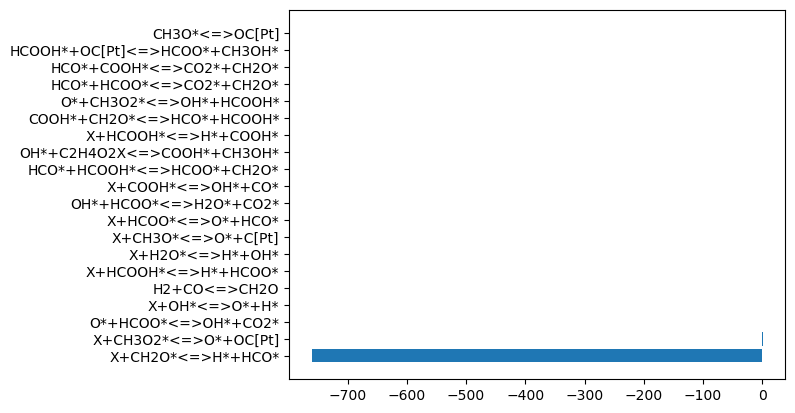

In [ ]:
%matplotlib inline
# get list of all rxns
rxn_strs = []
rxns_objs = []
for rxn in ssys.reactions: 
    rxn_strs.append(rms.getrxnstr(rxn))
    rxns_objs.append(rxn)

# I am assuming here that the rxns are in the same order as the sensitivity matrix
rxn_sens_dict = dict(zip(rxn_strs, sens_items_rxn))
# rxn_sens_dict = dict(zip(rxn_strs, sens_items))

# sort the dictionary by value
rxn_sens_dict_sort = dict(sorted(rxn_sens_dict.items(), key=lambda item: abs(item[1])))

# plot the top 10 most sensitive reactions
top10 = list(rxn_sens_dict_sort.items())[-20:]
top10.reverse()
rxn_strs = [x[0] for x in top10]
sens = [x[1] for x in top10]

plt.barh(rxn_strs, sens)
plt.savefig(os.path.join(rmg_model_folder, output_sens_file), dpi=300, bbox_inches='tight')
plt.show()

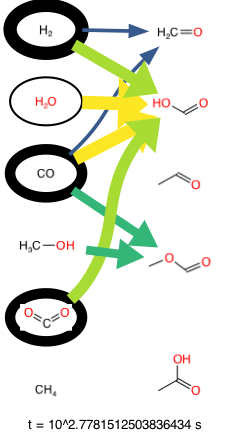

In [ ]:
rms.getfluxdiagram(ssys,600, centralspecieslist=['CO', 'CO2', 'CH3OH', 'H2'], radius=3, outputdirectory=output_flux_file)

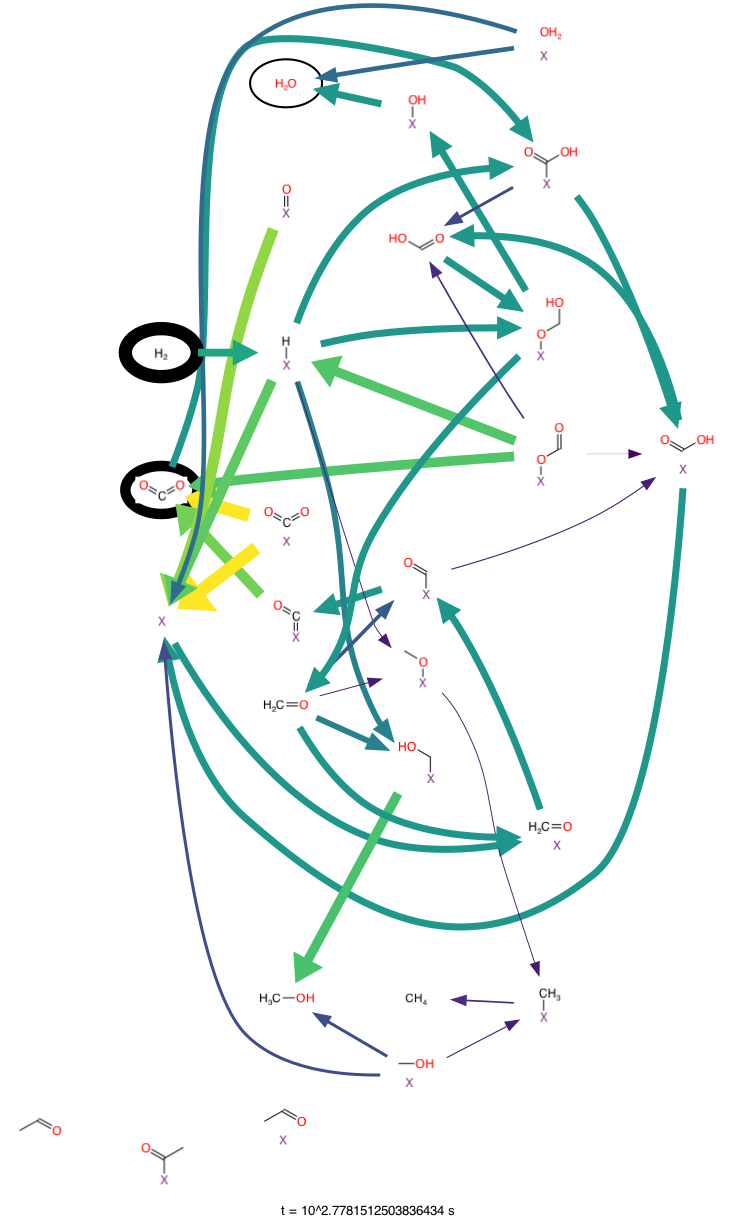

In [ ]:
rms.getfluxdiagram(ssys,600,outputdirectory=output_flux_file)

In [ ]:
# get list of reactions between ch2ohx and ch3x
from rmgpy.chemkin import load_chemkin_file
from rmgpy.rmg.model import ReactionModel

ck_model_path = os.path.join(rmg_model_folder, "chemkin", "chem_annotated-gas.inp")
species_dict_path = os.path.join(rmg_model_folder, "chemkin",  "species_dictionary.txt")
ck_surface_path = os.path.join(rmg_model_folder, "chemkin",  "chem_annotated-surface.inp")

model = ReactionModel()
model.species, model.reactions = load_chemkin_file(
    path=ck_model_path, 
    dictionary_path=species_dict_path,
    read_comments=True, 
    use_chemkin_names=True,
    surface_path = ck_surface_path,
)

In [ ]:
model.species[15:35]

[Species(index=11, label="O*", thermo=NASA(polynomials=[NASAPolynomial(coeffs=[-0.759016,0.0189869,-3.82475e-05,3.4356e-08,-1.13975e-11,-21835.6,1.76018], Tmin=(100,'K'), Tmax=(888.25,'K')), NASAPolynomial(coeffs=[1.89894,0.00203294,-1.19976e-06,2.32679e-10,-1.53507e-14,-22111.2,-9.64108], Tmin=(888.25,'K'), Tmax=(5000,'K'))], Tmin=(100,'K'), Tmax=(5000,'K'), comment="""Thermo library: surfaceThermoPt111 Binding energy corrected by LSR (1.00O) from Pt111"""), molecule=[Molecule(smiles="O=[Pt]")], molecular_weight=(15.9994,'amu')),
 Species(index=12, label="OH*", thermo=NASA(polynomials=[NASAPolynomial(coeffs=[-1.2952,0.0336484,-7.07746e-05,6.54354e-08,-2.19428e-11,-21645.4,4.37646], Tmin=(100,'K'), Tmax=(914.55,'K')), NASAPolynomial(coeffs=[2.43533,0.00464616,-2.39997e-06,4.26374e-10,-2.60626e-14,-21797.2,-10.3875], Tmin=(914.55,'K'), Tmax=(5000,'K'))], Tmin=(100,'K'), Tmax=(5000,'K'), comment="""Thermo library: surfaceThermoPt111 Binding energy corrected by LSR (0.50O) from Pt111"""),

### get reactions that have certain species as reactants or products

In [ ]:
# get reactant of interest
reac1 = model.species[8]

# get product of interest
prod1 = model.species[29]
display(reac1)
display(prod1)

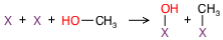

Average of [H2;VacantSite1;VacantSite2]
Estimated using template [Adsorbate;VacantSite1;VacantSite2] for rate rule [O-C;VacantSite1;VacantSite2]
Euclidian distance = 2.0
family: Surface_Adsorption_Dissociative
Ea raised from 30.8 to 31.3 kJ/mol to match endothermicity of reaction.


In [ ]:
reac_list = []
for reac in model.reactions:
    if reac1 in reac.reactants and prod1 in reac.products:
    # if prod1 in reac.products:
        reac_list.append(reac)
        display(reac) 
        print(reac.kinetics.comment)

In [ ]:
# save these reactions to pickle. 
with open("reac_list.pkl", 'wb') as f:
    pickle.dump(reac_list, f)

## 4. use the exported rms model and run for all expt conditions. plot tof on parity plot. 

In [ ]:
# run all the reactors in parallel
use_modified_rms = True
rmg_model_folder = os.path.join(repo_dir, "rmg_gua", "rmg_model",)
if use_modified_rms: 
    rms_file_path = os.path.join(rmg_model_folder, "rms", "chem_modified.yml")
    output_file_name = "rms_analysis_modified.csv"
else: 
    rms_file_path = get_highest_rms_file(rmg_model_folder)
    output_file_name = "rms_analysis_original.csv"

csv_path = os.path.join(rmg_model_folder, output_file_name)

# generate settings array
settings_yaml = os.path.join(repo_dir, "rmg_gua", "gua_cantera", "experiments_reorg_onlyopt.yaml")
with open(settings_yaml, 'r') as f:
    settings = yaml.safe_load(f)

def run_reactor(condts):

    # initialize reactor
    sbr_ss = rms_sbr(
        rms_file_path,
        reac_config = condts,
        rtol=1.0e-11,
        atol=1.0e-22,
    )

    results = sbr_ss.run_simulation()
    return results


# Too much memory? is that why it's slow?
# multiprocessing.set_start_method("spawn")
# with multiprocessing.Pool() as p:
#     result = p.map(run_reactor, settings)

result = []
# workaround: just run in serial
count = 0
ttot1 = time.time()
for condition in settings: 
    print("running ", count)
    
    t1 = time.time()
    res = run_reactor(condition)
    result.append(res)
    t2 = time.time()
    
    print(f"process took {t2-t1} seconds")

ttot2 = time.time()
print(f"all reactors took {ttot2-ttot1} seconds")

df = pd.DataFrame(result)

# post process results after pool is finished running
# we will only use runs where intraparticle diffusion limitations
# are not an issue, i.e. T < 518K
df_graaf = df[(df['T (K)'] < 518) & (df['experiment'] == 'graaf_1988') & (df['use_for_opt'] == True)]
df_graaf.to_csv(csv_path)

running  0
elapsed time for sim:  0.467235803604126
CC  not found in species list
CH4  not found in species list
process took 40.009886026382446 seconds
running  0
elapsed time for sim:  0.5434861183166504
CC  not found in species list
CH4  not found in species list
process took 3.684065103530884 seconds
running  0
elapsed time for sim:  0.572465181350708
CC  not found in species list
CH4  not found in species list
process took 3.807187080383301 seconds
running  0
elapsed time for sim:  0.32878994941711426
CC  not found in species list
CH4  not found in species list
process took 3.5217220783233643 seconds
running  0
elapsed time for sim:  0.3523600101470947
CC  not found in species list
CH4  not found in species list
process took 3.56402587890625 seconds
running  0
elapsed time for sim:  0.4856109619140625
CC  not found in species list
CH4  not found in species list
process took 3.433413028717041 seconds
running  0
elapsed time for sim:  0.5417091846466064
CC  not found in species list

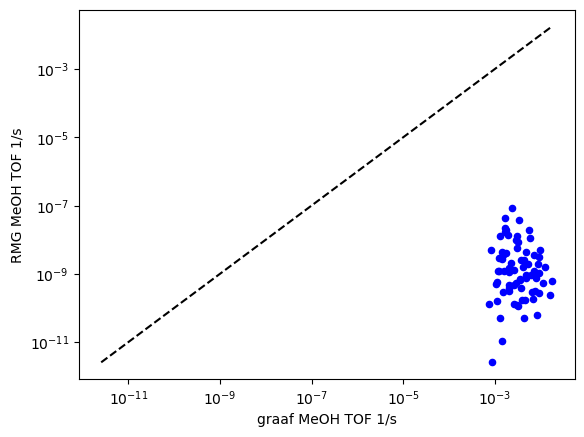

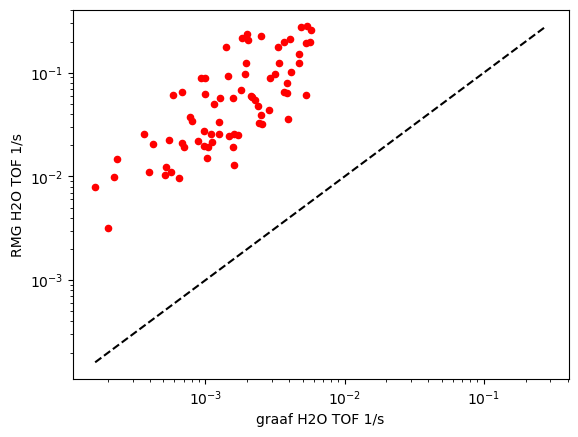

In [ ]:
# parity plot of the meoh tof


import numpy as np
csv_path = os.path.join(rmg_model_folder, "rms_analysis_original.csv")
df_graaf = pd.read_csv(csv_path)

meoh_max = max([df_graaf['graaf MeOH TOF 1/s'].max(), df_graaf['RMG MeOH TOF 1/s'].max()])
meoh_min = min([df_graaf['graaf MeOH TOF 1/s'].min(), df_graaf['RMG MeOH TOF 1/s'].min()])
meoh_line = np.logspace(np.log10(meoh_min), np.log10(meoh_max), 10)
plot1 = df_graaf.plot.scatter(x='graaf MeOH TOF 1/s', y='RMG MeOH TOF 1/s', c='blue', loglog=True)
plot1.plot(meoh_line,meoh_line, linestyle='--', c='black', )


# parity plot of the h2o tof
h2o_max = max([df_graaf['graaf H2O TOF 1/s'].max(), df_graaf['RMG H2O TOF 1/s'].max()])
h2o_min = min([df_graaf['graaf H2O TOF 1/s'].min(), df_graaf['RMG H2O TOF 1/s'].min()])
h2o_line = np.logspace(np.log10(h2o_min), np.log10(h2o_max), 10)
plot2 = df_graaf.plot.scatter(x='graaf H2O TOF 1/s', y='RMG H2O TOF 1/s', c='red', loglog=True)
plot2.plot(h2o_line, h2o_line,linestyle='--', c='black', )

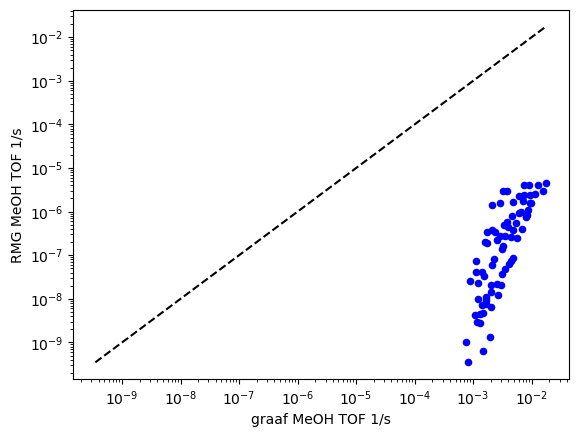

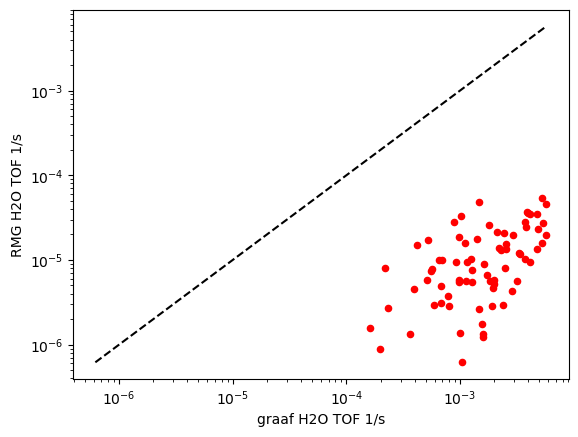

In [ ]:
# exact same code as above, except df_graaf is now df_graaf_modified
# parity plot of the meoh tof
csv_path = os.path.join(rmg_model_folder, "rms_analysis_modified.csv")
df_graaf_modified = pd.read_csv(csv_path)

meoh_max = max([df_graaf_modified['graaf MeOH TOF 1/s'].max(), df_graaf_modified['RMG MeOH TOF 1/s'].max()])
meoh_min = min([df_graaf_modified['graaf MeOH TOF 1/s'].min(), df_graaf_modified['RMG MeOH TOF 1/s'].min()])
meoh_line = np.logspace(np.log10(meoh_min), np.log10(meoh_max), 10)
plot1 = df_graaf_modified.plot.scatter(x='graaf MeOH TOF 1/s', y='RMG MeOH TOF 1/s', c='blue', loglog=True)
plot1.plot(meoh_line,meoh_line, linestyle='--', c='black', )

# parity plot of the h2o tof
h2o_max = max([df_graaf_modified['graaf H2O TOF 1/s'].max(), df_graaf_modified['RMG H2O TOF 1/s'].max()])
h2o_min = min([df_graaf_modified['graaf H2O TOF 1/s'].min(), df_graaf_modified['RMG H2O TOF 1/s'].min()])
h2o_line = np.logspace(np.log10(h2o_min), np.log10(h2o_max), 10)
plot2 = df_graaf_modified.plot.scatter(x='graaf H2O TOF 1/s', y='RMG H2O TOF 1/s', c='red', loglog=True)
plot2.plot(h2o_line, h2o_line,linestyle='--', c='black', )

In [ ]:
sens_rxn_obj_dict = {}
top10_dict = dict(top10)
for rxn in rxns_objs: 
    rxn_str = rms.getrxnstr(rxn)
    if rxn_str in top10_dict.keys():#and rxn_str not in sens_rxn_obj_dict.keys():
        sens = abs(rxn_sens_dict[rxn_str])
        print("sens: ", sens, "rxn: ", rxn_str)
        reac_spec = [make_spc(reac) for reac in rxn.reactants]
        prod_spec = [make_spc(prod) for prod in rxn.products]
        sens_rxn_obj_dict[rxn_str] = (sens, reac_spec, prod_spec)
sens_rxn_obj_dict

sens:  6.300549456876386e-14 rxn:  H2+CO<=>CH2O


NameError: name 'make_spc' is not defined

In [ ]:
# now match up the rms reaction sensitivities with the actual rxn in chemkin
# match species does forward and reverse. if there are multiple matches, it will
# print a warning.
match_list = []
sens_cmkn_dict = {}
for rxn_str, entry in sens_rxn_obj_dict.items():
    for rxn in model.reactions:
        counter = 0
        if rxn.matches_species(entry[1],entry[2]):
            print("match : ", rxn_str, counter)
            match_list.append(rxn_str)
            sens_cmkn_dict[rxn_str] = (entry[0], rxn)
        counter += 1
        if counter >=2: 
            print("more than 1 match found for ", rxn_str)
if len(match_list) == len(sens_rxn_obj_dict.keys()):
    print("all matches found")
else: 
    for rxn_str, entry in sens_rxn_obj_dict.items():
        if rxn_str not in match_list:
            print("no match found for ", rxn_str)

# use max key because we have taken abs(sensitivity)
max_key = max(sens_cmkn_dict, key=sens_cmkn_dict.get)
most_sens_rxn = sens_cmkn_dict[max_key][1]

# now pickle the most sensitive reaction
cmkn_pickle_path = os.path.join(rmg_model_folder, "sens_cmkn_dict.pickle")
with open(cmkn_pickle_path, "wb") as f:
    pickle.dump(most_sens_rxn, f)


In [ ]:
most_sens_rxn.get_source()